In [64]:
import sys
sys.path.insert(1,'../')

In [2]:
import os
import PPGN.models
import torch
import torch.nn.functional as F
from PPGN.models.base_model import BaseModel
import torch
import torch.nn as nn
import PPGN.layers.layers as layers
import PPGN.layers.modules as modules

/home/math/maskey/anaconda3/envs/glpe/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class BaseModel(nn.Module):
    def __init__(self, K):
        """
        Build the model computation graph, until scores/values are returned at the end
        """
        super().__init__()

        self.use_new_suffix = True
        block_features = [128,128,128,128,K] # List of number of features in each regular block
        original_features_num = K + 1  # Number of features of the input
        #self.num_classes = K

        # First part - sequential mlp blocks
        last_layer_features = original_features_num
        self.reg_blocks = nn.ModuleList()
        for layer, next_layer_features in enumerate(block_features):
            mlp_block = modules.RegularBlock(last_layer_features, next_layer_features)
            self.reg_blocks.append(mlp_block)
            last_layer_features = next_layer_features

        # Second part
        self.fc_layers = nn.ModuleList()
        """
        if self.use_new_suffix:
            for output_features in block_features:
                # each block's output will be pooled (thus have 2*output_features), and pass through a fully connected
                fc = modules.FullyConnected(2*output_features, num_classes, activation_fn=None)
                self.fc_layers.append(fc)

        else:  # use old suffix
            # Sequential fc layers
            self.fc_layers.append(modules.FullyConnected(2*block_features[-1], 512))
            self.fc_layers.append(modules.FullyConnected(512, 256))
            self.fc_layers.append(modules.FullyConnected(256, num_classes, activation_fn=None))
        """

    def forward(self, input):
        x = input
        scores = torch.tensor(0, device=input.device, dtype=x.dtype)

        for i, block in enumerate(self.reg_blocks):

            x = block(x)
            #scores = x          
            #scores = scores + x
            #if self.use_new_suffix:
                # use new suffix
                #print(scores)
                #scores = self.fc_layers[i](layers.diag_offdiag_maxpool(x)) + scores
        """
        if not self.use_new_suffix:
            # old suffix
            x = layers.diag_offdiag_maxpool(x)  # NxFxMxM -> Nx2F
            for fc in self.fc_layers:
                x = fc(x)
            scores = x
        """
            
        mat = x.squeeze()
        matt = torch.diagonal(mat, dim1=-2, dim2=-1)
        mattt = matt.transpose(-1,-2)   
        mattt,_ = torch.qr(mattt)
        #print(mattt[0,0])
        
        return mattt

A = torch.rand(64,64)
b1 = torch.rand(64)
b2 = torch.rand(64)
b3 = torch.rand(64)
b4 = torch.rand(64)
b5 = torch.rand(64)

B1=torch.diag(b1)
B2=torch.diag(b2)
B3=torch.diag(b3)
B4=torch.diag(b4)
B5=torch.diag(b5)

A = A.unsqueeze(dim=0)

B1 = B1.unsqueeze(dim=0)
B2 = B2.unsqueeze(dim=0)
B3 = B3.unsqueeze(dim=0)
B4 = B4.unsqueeze(dim=0)
B5 = B5.unsqueeze(dim=0)

hi  = torch.cat((A,B1,B2,B3,B4,B5),0)

hi.shape
hi.unsqueeze_(dim=0)

hello = bm.forward(hi)

In [4]:
import os.path as osp
import torch
# from torch_geometric.loader import DataLoader
import torch.optim as optim
import torch.nn.functional as F
# from gnn import GNN
from torch import Tensor

from tqdm import tqdm
import argparse
import time
import numpy as np
# import geotorch
import geoopt

### importing OGB
# from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.utils import to_networkx, to_dense_adj
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch_geometric.datasets import Planetoid
from ogb.nodeproppred import Evaluator

import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader

import torch
import argparse
from timeit import default_timer as timer
import torch
import torch.nn.functional as F
import torch.nn as nn
# from numba import jit

from typing import Any, Optional
from torch_geometric.data import Data

In [5]:
def my_loss(F, XX, pp):
    """
    X: (N x N)-tensor with adjacency matrix
    F: (N x F)-tensor with eigenvectors
    """
    #mat = F.squeeze()
    #matt = torch.diagonal(mat, dim1=-2, dim2=-1)
    #mattt = matt.transpose(-1,-2)   
    #mattt,_ = torch.qr(mattt)
    #f = mattt
    f = F
    n = f.shape[0]
    FF = f.repeat(1,n)
    FF = FF.reshape(n,n,f.shape[1])
    FFF = torch.norm(f, pp,dim=0)
    FFF = torch.pow(FFF,pp)
    FF = FF.transpose(2,0)
    GG = FF.transpose(1,2)
    A = XX.unsqueeze(dim=1)
    KK = FF - GG
    KKK = KK.unsqueeze(dim=-1)
    KKK = torch.pow(torch.abs(KKK),pp)
    KKK = KKK.type(torch.float64)
    A = A.type(torch.float64)
    LL = torch.matmul(A, KKK)
    FFF = torch.pow(FFF,-1)
    FFF.unsqueeze_(-1)
    FFF.unsqueeze_(-1)
    FFF.unsqueeze_(-1)
    FFF = FFF.repeat(1,n,1,1)
    b = torch.matmul(LL.float(),FFF)
    b = torch.sum(b)
    return b

In [6]:
def make_2d_graph(m, n, periodic=False, return_pos=False):
    network = nx.grid_2d_graph(m, n, periodic=False, create_using=None)
    matrix = nx.linalg.graphmatrix.adjacency_matrix(network).todense()
    matrix = np.array(matrix).astype(float)
    return matrix

def get_graph_props(A, normalize_L='none', shift_to_zero_diag=False):
    ran = range(A.shape[0])

    D = np.zeros_like(A)
    D[ran, ran] = np.abs(np.sum(A, axis=1) - A[ran, ran])
    L = D - A

    if (normalize_L is None) or (normalize_L=='none') or (normalize_L == False):
        pass
    elif (normalize_L == 'inv'):
        Dinv = np.linalg.inv(D)
        L = np.matmul(Dinv, L)  # Normalized laplacian
    elif (normalize_L == 'sym'):
        Dinv = np.sqrt(np.linalg.inv(D))
        L = np.matmul(np.matmul(Dinv, L), Dinv)
    elif (normalize_L == 'abs'):
        L = np.abs(L)
    else:
        raise ValueError('unsupported normalization option')

    eigval, eigvec = np.linalg.eigh(L)
    eigval =  np.real(eigval)
    # eigidx = np.argsort(eigval)[::-1]
    eigidx = np.argsort(eigval)
    eigval = eigval[eigidx]
    eigvec = eigvec[:, eigidx]


    L_inv = np.linalg.pinv(L)

    if shift_to_zero_diag:
        L_inv_diag = L_inv[np.eye(L.shape[0])>0]
        L_inv = (L_inv - L_inv_diag[:, np.newaxis])

    return D, L, L_inv, eigval, eigvec

In [7]:
import networkx as nx

In [8]:
grid_sizes = [(16,4)]
num_eigs = 5 #gives the dimension of the embedding or: num_eigs - 1 is the number of eigenvectors we calculate
K = num_eigs
plot_labels = False
add_side_plots = True

A = make_2d_graph(grid_sizes[0][0],grid_sizes[0][1], periodic=False) 
print(A.shape)
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

(64, 64)


/tmp/ipykernel_25744/349077273.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.linalg.graphmatrix.adjacency_matrix(network).todense()


In [9]:
init_eigs = eigvec[:,:K]

In [10]:
init_eigs.shape

(64, 5)

In [11]:
A_ = torch.tensor(A)
F_ = torch.tensor(init_eigs)

In [12]:
A_.shape

torch.Size([64, 64])

In [13]:
F_ = F_.transpose(-1,0)

In [14]:
F=torch.diag(F_[0,:])
F=F.unsqueeze(dim=0)

In [15]:
F_.shape

torch.Size([5, 64])

In [16]:
for i in range(1,F_.shape[0]):
    FF = torch.diag(F_[i,:])
    FF=FF.unsqueeze(dim=0)
    F=torch.cat((F, FF), 0)

In [17]:
F.shape

torch.Size([5, 64, 64])

In [18]:
AA = A_.unsqueeze(dim=0)

In [19]:
inp = torch.cat((AA,F),0)

In [20]:
inp = inp.unsqueeze(dim=0)

In [21]:
inp.shape

torch.Size([1, 6, 64, 64])

### From here we start the model instantiation and trainingdevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
bm = BaseModel(K).to(device)
p=1
X=torch.tensor(A).to(device)
epocs = 100

In [35]:
def training_loop1(model, optimizer, sched,W, epochs=25):
    "Training loop for torch model."
    losses = []
    values = []
    for i in range(epochs):
        preds = model(W)
        loss = my_loss(preds, X, p)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)
        values.append(preds)
    return losses, values

optimizer = torch.optim.RMSprop(bm.parameters(), lr=0.0001)
my_lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [36]:
start = timer()
#for i in range(0,10):
#  losses = training_loop1(m, opt,scheduler)
#end = timer()
losses, values = training_loop1(bm, optimizer,my_lr_scheduler,inp.float().to(device), epocs) 
end = timer()
print(end - start, " second")

1.4235441639903001  second


In [37]:
one_evs = bm(inp.float().to(device))

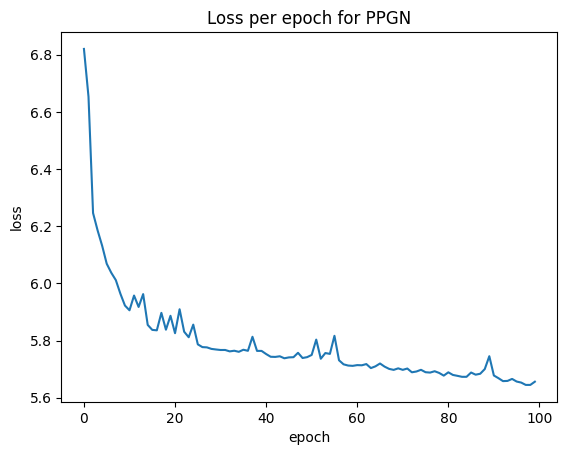

In [38]:
import matplotlib.pyplot as plt
loss = [x.to('cpu').detach().numpy() for x in losses]
x = np.arange(0,epocs)
y = np.array(loss)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Loss per epoch for PPGN")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('LossesWithoutQR.png')
plt.show()


mat = one_evs.squeeze()
matt = torch.diagonal(mat, dim1=-2, dim2=-1)
mattt = matt.transpose(-1,-2)   
mattt, _ = torch.qr(mattt)

In [33]:
from numba import jit

In [34]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def phi(x, p):
  return np.abs(x)**(p-1)*np.sign(x)

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def lp_norm(x, p):
  #gives the p-th power of the lp-norm
  y = np.sum(np.power(np.abs(x),p))
  return y

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def jacobian_grad(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  B = np.zeros((f.shape[0], f.shape[1]))
  for i in range(0, f.shape[0]):
    for k in range(0, f.shape[1]):
      helper = [ A[i,j]*phi(f[i,k] - f[j,k],p)  for j in range(0, f.shape[0]) ]
      grad = np.sum(np.array(helper))
      grad = grad - phi(f[i,k],p)/lp_norm(f[:,k], p)
      grad = 1/lp_norm(f[:,k], p) * grad
      B[i,k] = grad
  return B

def calc_grad(A, f,p):
#implements G in Algorithm 1
  grad = jacobian_grad(A, f, p)
  G = grad - np.matmul(np.matmul(f,np.transpose(grad)),f)
  step_size = lp_norm(f, 1)/lp_norm(G,1) #for the adaptive stepsize
  return G, step_size

In [35]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def derivative(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  sum_rows = 0
  for i in range(0,A.shape[0]):
    sum_cols = 0
    for j in range(0,A.shape[1]):
      sum_cols = sum_cols + A[i,j]*(np.abs(f[i] - f[j])**p)/(2*lp_norm(f,p)+eps)
    sum_rows = sum_rows + sum_cols
  B = np.zeros(f.shape[0])
  for m in range(f.shape[0]):
    helper = [A[m,j]*phi(f[m] - f[j], p) for j in range(A.shape[0])]
    grad = np.sum(np.array(helper))
    B[m] = p/(lp_norm(f,p)+eps)*(grad- (phi(f[m],p)*sum_rows))
  return B

In [36]:
hello = []
eps = 2.220446049250313e-8
for i in range(epocs):
  #print(values[i][:,1].cpu().detach().numpy())
  hello.append( np.linalg.norm(derivative(A, values[i][:,1].cpu().detach().numpy(), 1)))

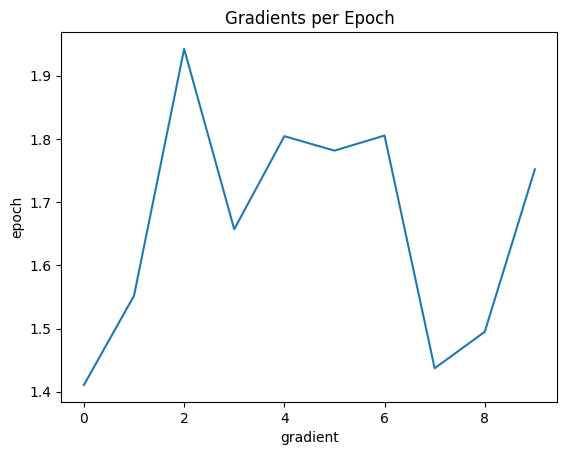

In [37]:
import matplotlib.pyplot as plt
loss = [x for x in hello]
x = np.arange(0,epocs)
y = np.array(loss)
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Gradients per Epoch")
plt.xlabel("gradient")
plt.ylabel("epoch")
plt.savefig('GradienWithQR.png')
plt.show()

In [38]:
import matplotlib.pyplot as plt

p =  1  step size =  0.01


/tmp/ipykernel_25744/349077273.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.linalg.graphmatrix.adjacency_matrix(network).todense()


<Figure size 640x480 with 0 Axes>

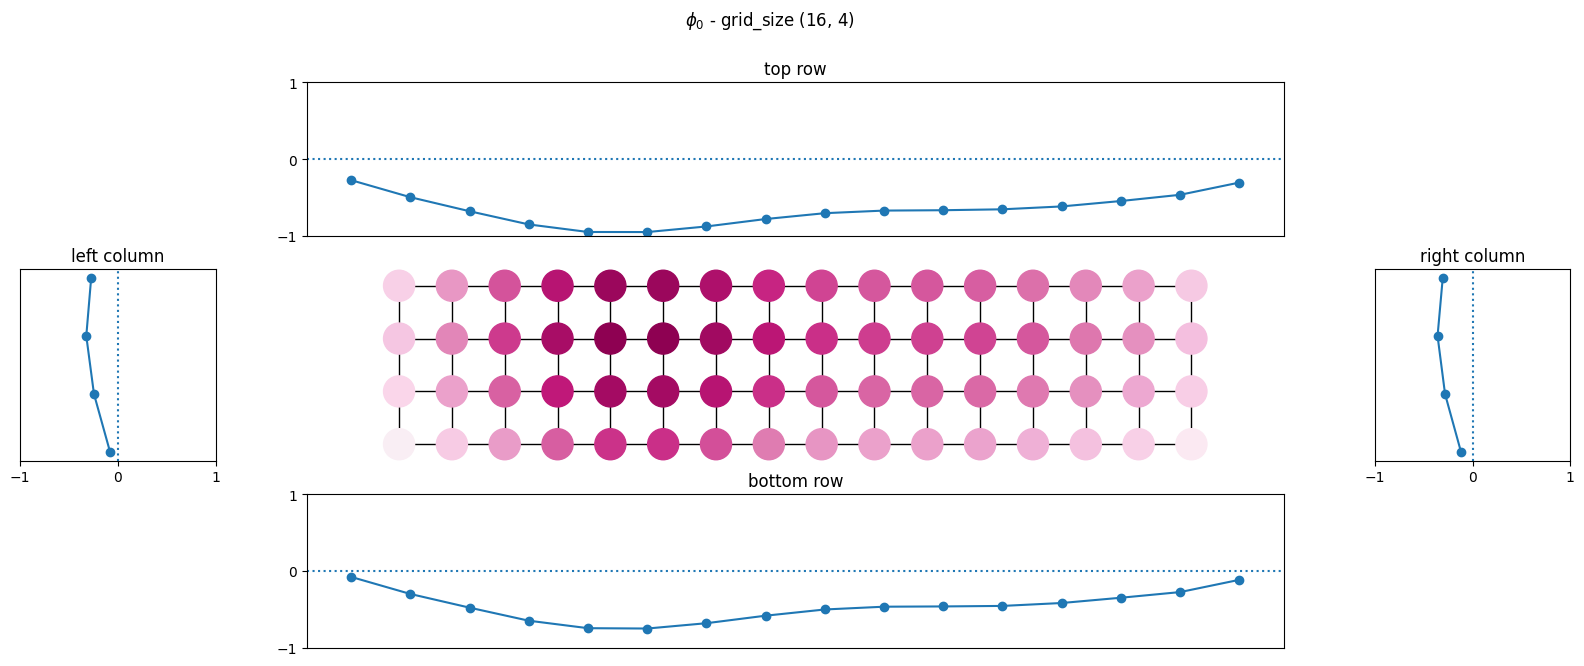

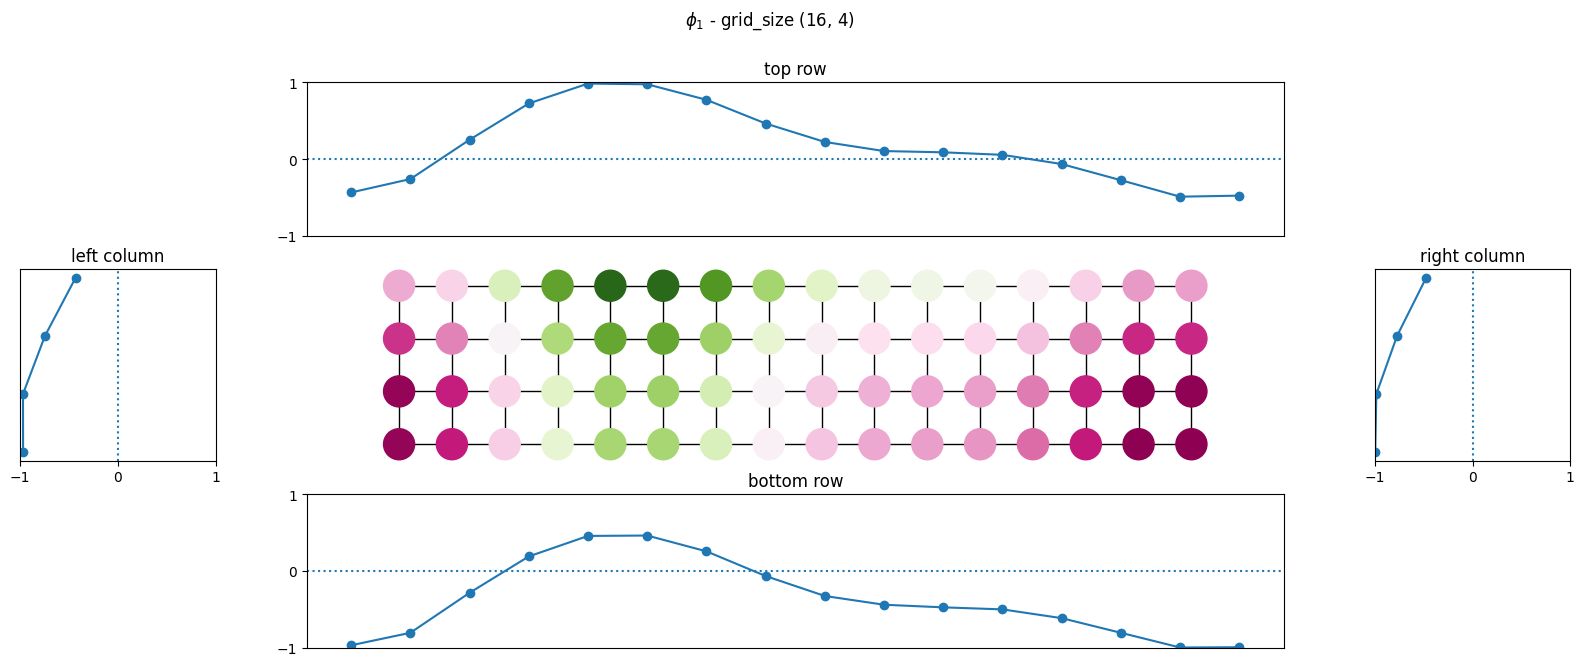

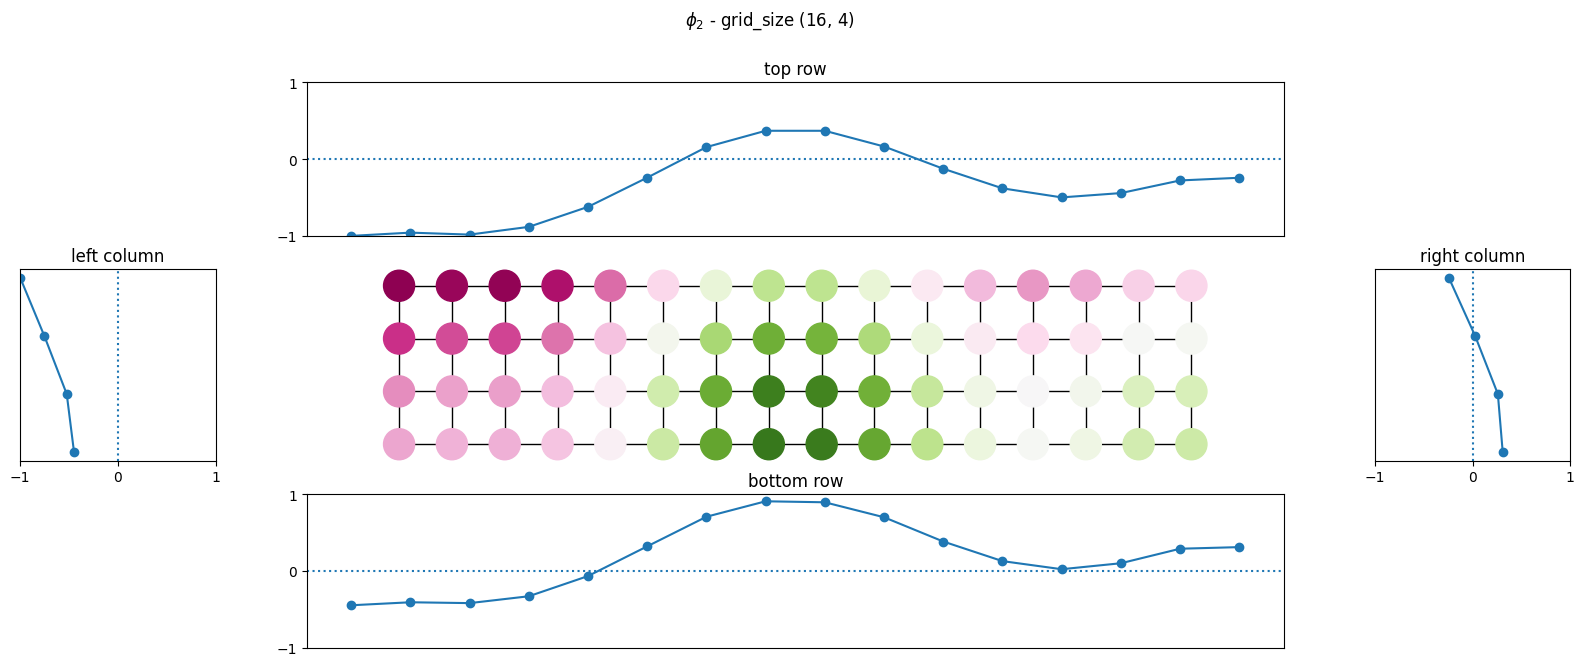

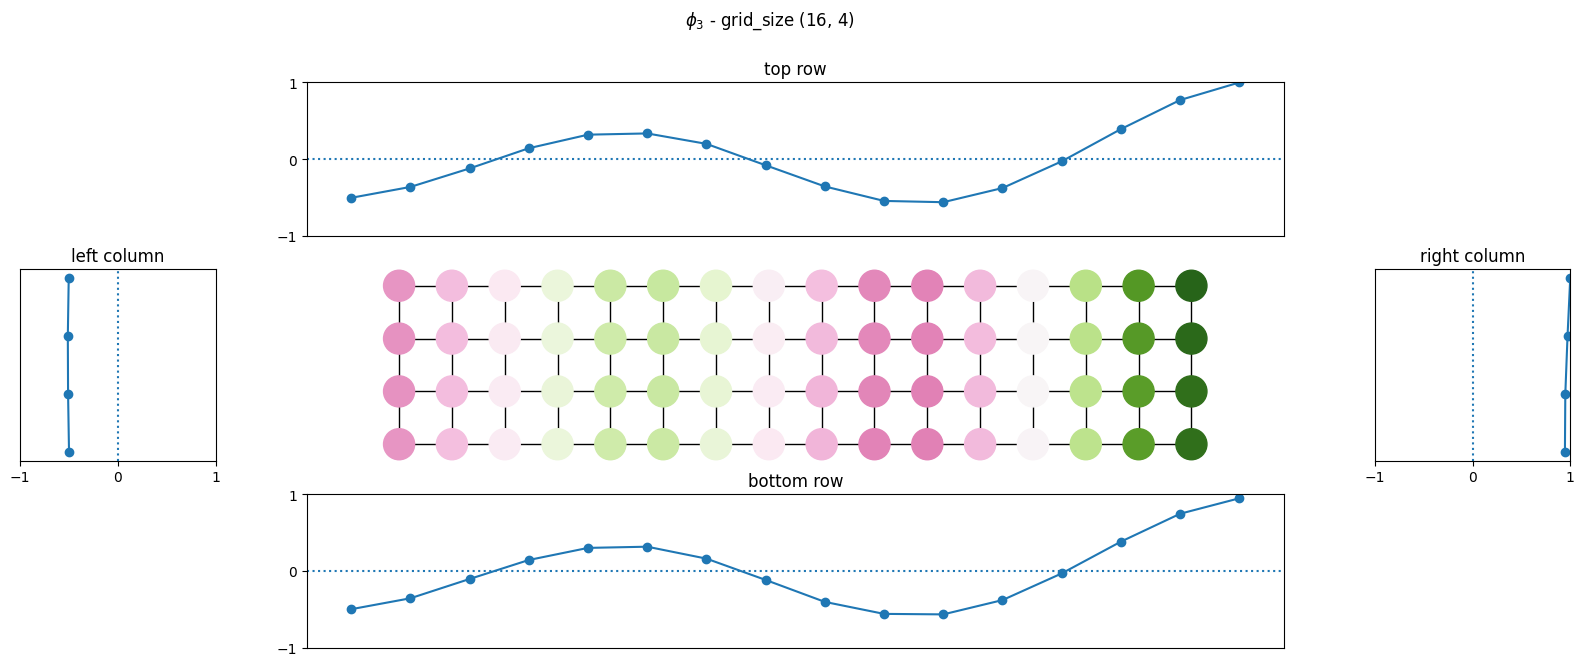

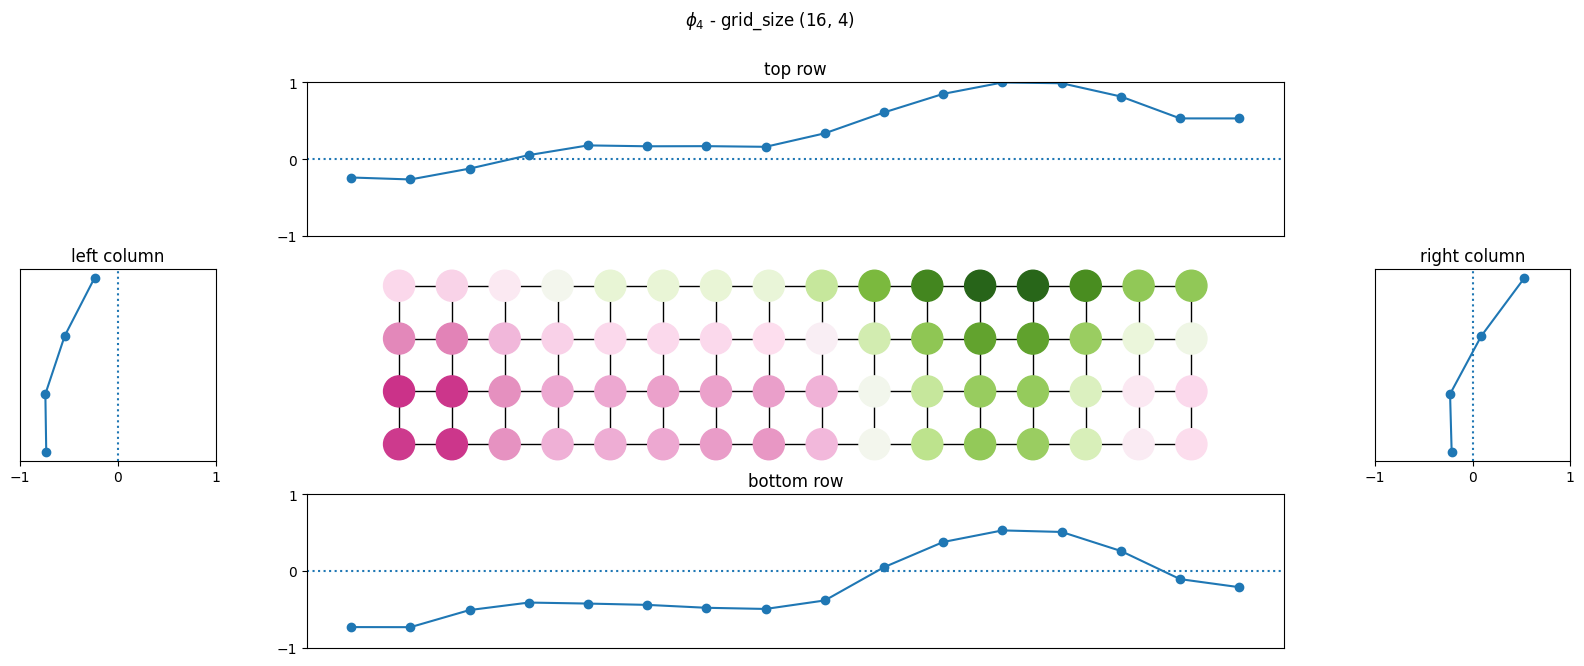

In [28]:
for p in range(1,2):
  p = 1
  alpha = 0.01
  #F = init_eigvec[:, 0:num_eigs]
  print('p = ', p, ' step size = ', alpha)

  
  #for i in range(0,steps):
    #should give us the full approximation matrix of p-eigenfunctions
    #k'th row is the embedding of node k
  #  grad, ss = calc_grad(A, F, p)
  #  F = F - alpha*ss*grad

  for grid_size in grid_sizes:

      # Initialize figure sizes
      size_factor = 5 / grid_size[1]
      node_size = 800 * size_factor
      figsize = [g * size_factor for g in grid_size]

      # Initialize adjacency
      A = make_2d_graph(*grid_size, periodic=False) 
      # print(A)

      # Get graph, laplacian, spacial positions
      # D, L, L_inv, eigval,eigvec = get_graph_props(A)
      p_eigvec = np.array(one_evs.cpu().detach().numpy())
      fig = plt.figure()
      # plt.scatter(np.arange(A.shape[0]), L_inv[0, :])
      graph = nx.from_numpy_array(A)
      pos = [(ii, jj) for ii in range(grid_size[0]) for jj in range(grid_size[1])]

      # Plot all the eigenvectors
      #for ii in range(num_eigs-1):
      for ii in range(K):

          im_dir = f'images_out/Eig grid side plots/grid-size-{grid_size}/'

          # Prepare the figure and subplots
          if add_side_plots:
              grid_factor = grid_size[1]/grid_size[0]
              new_fig_factor = np.sqrt((5*grid_factor + 2) / 7)
              new_figsize = [figsize[0], figsize[1]/new_fig_factor]
              f, axes = plt.subplots(3, 3, figsize=new_figsize,
                  gridspec_kw={'width_ratios': [1, 5, 1], 'height_ratios': [1, 5*grid_factor, 1]})
              f.suptitle(f'$\phi_{ii}$ - grid_size {grid_size}')
              axes[0, 0].axis('off')
              axes[0, 2].axis('off')
              axes[2, 0].axis('off')
              axes[2, 2].axis('off')
              plt.sca(axes[1, 1])
              new_node_size = node_size * 0.5
              
          else:
              plt.figure(figsize=figsize)
              new_node_size = node_size
              im_dir = f'images_out/Eig grid/grid-size-{grid_size}/'
          
          # Plot the colored graph with eigenvectors
          node_vals = np.real(p_eigvec[:, ii])
          node_vals /= np.max(np.abs(node_vals)) + 1e-6
          labels = {ii: '{:.3f}'.format(node_vals[ii]) for ii in range(len(node_vals))} if plot_labels else {}
          plt.gca().set_aspect('equal')
          nx.draw(graph, pos=pos, node_color=node_vals, vmin=-1, vmax=1, cmap='PiYG', 
                  labels=labels, node_size=new_node_size, ax=plt.gca())
          

          if add_side_plots:
              # Plot the eigenvectors on left
              y = np.arange(grid_size[1])
              axes[1, 0].plot(node_vals[:grid_size[1]], y, marker='o')
              axes[1, 0].set_xlim(-1, 1)
              axes[1, 0].set_xticks([-1, 0, 1])
              axes[1, 0].set_yticks([])
              axes[1, 0].axvline(0, linestyle=':')
              axes[1, 0].set_title('left column')

              # Plot the eigenvectors on the right
              axes[1, 2].plot(node_vals[-grid_size[1]:], y, marker='o')
              axes[1, 2].set_xlim(-1, 1)
              axes[1, 2].set_xticks([-1, 0, 1])
              axes[1, 2].set_yticks([])
              axes[1, 2].axvline(0, linestyle=':')
              axes[1, 2].set_title('right column')

              # Plot the eigenvectors on bottom
              x = np.arange(grid_size[0])
              axes[2, 1].plot(x, node_vals[::grid_size[1]], marker='o')
              axes[2, 1].set_ylim(-1, 1)
              axes[2, 1].set_xticks([])
              axes[2, 1].set_yticks([-1, 0, 1])
              axes[2, 1].axhline(0, linestyle=':')
              axes[2, 1].set_title('bottom row')

              # Plot the eigenvectors on top
              axes[0, 1].plot(x, node_vals[grid_size[1]-1::grid_size[1]], marker='o')
              axes[0, 1].set_ylim(-1, 1)
              axes[0, 1].set_xticks([])
              axes[0, 1].set_yticks([-1, 0, 1])
              axes[0, 1].axhline(0, linestyle=':')
              axes[0, 1].set_title('top row')

              # fig.savefig(f'./phi_{ii}.png')
              plt.show()
              # print(ii, node_vals)


In [43]:
data =  np.load('../results/ts_loss_gin_p2.npy')

In [44]:
data2 =   np.load('../results/ts_loss_simple.npy')

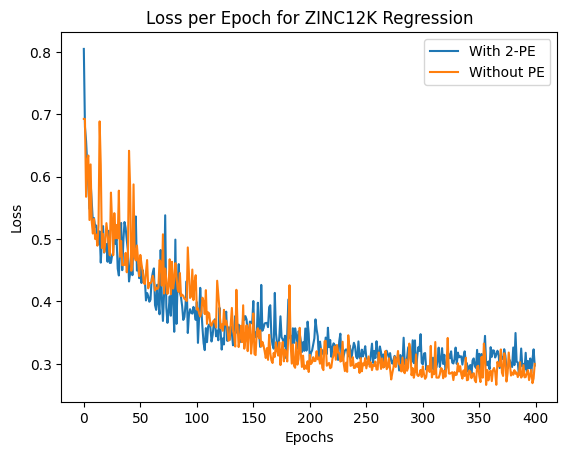

In [53]:
# Plotting the Graph
x = np.arange(0,400)
y = np.array(data)
yy =  np.array(data2)
plt.plot(x, y, label="With 2-PE")
plt.plot(x, yy, label="Without PE")
plt.title("Loss per Epoch for ZINC12K Regression")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_ZINC12K_Withp2LPE.png')
plt.show()

In [54]:
x = torch.randn(10)

In [65]:
!ls

GradienWithoutQR.png  LossesWithoutQR.png  loss_ZINC12K_Withp2LPE.png
GradienWithQR.png     LossesWithQR.png	   PPGN_Tests.ipynb


In [69]:
import importlib  
Zinc12KDataset = importlib.import_module("../graph-task/libs/utils.py")

TypeError: the 'package' argument is required to perform a relative import for '../graph-task/libs/utils.py'

In [58]:
from graph-task.libs.utils import Zinc12KDataset,SpectralDesign,get_n_params

SyntaxError: invalid syntax (3926530276.py, line 1)

In [ ]:
transform = SpectralDesign(nmax=37,recfield=2,dv=2,nfreq=7) 

#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform)
#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform) #For Ali

########## commented this:
dataset = Zinc12KDataset(root="dataset/ZINC/",pre_transform=transform)